In [1]:
#####Evolving the parameters of the adaptive mechanism from Williams & Noble (2007)#####
#####and then examining the effect on the "region of viability" for a legged walker#####

import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
##create CTRNN

def sigmoid(x):
    return 1/(1+np.exp(-x))
def invsigmoid(x):
    return np.log(x/(1-x))

sigmoid(invsigmoid(.2))

0.2

In [30]:
class CTRNN():

    def __init__(self,size,dt,duration,slidingwindow,weights,biases,timeconsts):
        self.Size = size                                         # number of neurons in the circuit
        self.States = np.ones(size)                              # state of the neurons
        self.Outputs = np.zeros(size)                            # neuron outputs
        self.PlasticFacilitation = np.zeros(size)                #value of rho for each neuron to use in adaptive mech
        self.dt = dt                                             #size of walking timestep
        self.duration = duration                                 #duration in seconds
        self.time = np.arange(0.0,self.duration,dt)              #timeseries values in seconds
        self.ctrnn_record = np.zeros((size,len(self.time)))      #place to store data of the node firing rates over time
        self.Stepnum = 0                                         #initialize the step count at 0
        self.slidingwindow = slidingwindow                       #how far back to go in timesteps to calculate avg_firingrate (& avg_speed)
        self.max_firingrate = np.zeros(self.Size)                #keep track of the maximum firing rate (for diagnostic b/c place in the cycle varies it)
        self.min_firingrate = np.ones(self.Size)                 #keep track of the minimum firing rate (for diagnostic)
        self.Weights = np.copy(weights)
        self.Biases = np.copy(biases)
        self.invTimeConstants = 1.0/np.copy(timeconsts)
        self.bias_record = np.zeros((size,len(self.time)))       #since parameters of the system are changing under the adaptive mechanism, track them
        self.weight_record = np.zeros((size,size,len(self.time)))#not general, but okay for now
        self.Inputs = np.zeros((size))
             
    def resetStepcount(self):
        self.Stepnum = 0
        
    def setInputs(self,inputs): #external input to each neuron
        self.Inputs = inputs
    
    def setWeights(self, weights): #weight of connection for each neuron pair, going from row (i) to column (j)
        self.Weights = np.copy(weights)
        
    def randomizeWeights(self):
        self.Weights = np.random.uniform(-10,10,size=(self.Size,self.Size))

    def setBiases(self, biases): #bias shift for each neuron
        self.Biases =  np.copy(biases)
    
    def randomizeBiases(self):
        self.Biases = np.random.uniform(-10,10,size=(self.Size))

    def setTimeConstants(self, timeconstants): #time constant for each neuron
        self.TimeConstants =  np.copy(timeconstants)
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def randomizeTimeConstants(self):
        self.TimeConstants = np.random.uniform(0.1,5.0,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def setAdaptiveTimeConstants(self, adaptiveWtimeconstants, adaptiveBtimeconstants): #time constants for the adaptation of the weights & biases
        self.invadaptWTimeConsts = 1.0/np.copy(adaptiveWtimeconstants)
        self.invadaptBTimeConsts = 1.0/np.copy(adaptiveBtimeconstants)
        
    def randomizeAdaptiveTimeConstants(self):
        self.invadaptWTimeConsts = 1.0/np.random.uniform(10,50,self.Size)
        self.invadaptBTimeConsts = 1.0/np.random.uniform(10,50,self.Size)
        
    def setFacilitationFunctionParams(self,pLows,pHighs,pSlopes): #the parameters for the plastic facilitation function to determine rho
        self.pLows = pLows
        self.pHighs = pHighs
        self.pSlopes = pSlopes #always <0
        
    def randomizeFacilitationFunctionParams(self):
        self.pLows = np.random.uniform(.01,.49,self.Size)  #between .01 and .49 initially, although strictly only has to be lower than pHigh
        self.pHighs = np.random.uniform(.51,.99,self.Size) #between .51 and .99 initially, although strictly only has to be higher than pLow
        self.pSlopes = np.random.uniform(-10,0,self.Size)  #always <0

    def initializeState(self, s):
        self.States = s
        self.Outputs = sigmoid(self.States+self.Biases)
        
    def plasticFacilitationCalc(self): #calculate and update the value of rho for each neuron, using the mean firing rate from the preceding segment of runtime
        for i in range(self.Size):
            if self.Stepnum < self.slidingwindow:
                self.PlasticFacilitation[i] = 0   #yet not enough data to evaluate average firing rate (don't want to use instantaneous firing rate bc it oscillates)
            else:
                avg_firingrate = np.mean(self.ctrnn_record[i,self.Stepnum-self.slidingwindow:self.Stepnum])
                if avg_firingrate > self.max_firingrate[i]:
                    self.max_firingrate[i] = avg_firingrate
                if avg_firingrate < self.min_firingrate[i]:
                    self.min_firingrate[i] = avg_firingrate
                #if self.Stepnum==self.slidingwindow or self.Stepnum == self.duration:
                    #print(avg_firingrate)
                if  avg_firingrate < self.pLows[i]:
                    self.PlasticFacilitation[i] = self.pSlopes[i]*(avg_firingrate - self.pLows[i] )
                elif avg_firingrate > self.pHighs[i]:
                    self.PlasticFacilitation[i] = self.pSlopes[i]*(avg_firingrate - self.pHighs[i])
                else:
                    self.PlasticFacilitation[i] = 0  #if in range, no change 
    
    def updateBiases(self): #use the value of rho for each neuron to dynamically change biases, scaling the change by 1/speed of walking
        for i in range(self.Size):
            self.Biases[i] += self.dt * self.invadaptBTimeConsts[i] * self.PlasticFacilitation[i]
            if self.Biases[i] >= 16:
                self.Biases[i] = 16
            if self.Biases[i] <= -16:
                self.Biases[i] = -16
    
    def updateWeights(self): #use the value of rho for each neuron to dynamically change all incoming weights to that neuron, scaling the change by 1/speed of walking
        for j in range(self.Size):
            incomingWeights = self.Weights[:,j]
            incomingWeights += self.dt * self.invadaptWTimeConsts[j] * self.PlasticFacilitation[j] * np.absolute(incomingWeights)
            self.Weights[:,j] = incomingWeights
            for i in range(self.Size):
                if self.Weights[i,j] >= 16:
                    self.Weights[i,j] = 16
                if self.Weights[i,j] <= -16:
                    self.Weights[i,j] = -16
        
    def ctrnnstep(self,adapt): #use the value of the weights and outputs to change the state of each neuron
        #if adapt = true, then we are implementing the adaptive mechanism
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += self.dt * (self.invTimeConstants*(-self.States+netinput))        
        self.Outputs = sigmoid(self.States+self.Biases)
        self.ctrnn_record[:,self.Stepnum] = self.Outputs
        if adapt == True:
            self.bias_record[:,self.Stepnum]=self.Biases
            self.weight_record[:,:,self.Stepnum]=self.Weights
            self.plasticFacilitationCalc()
            self.updateBiases()
            self.updateWeights()
        self.Stepnum += 1
        
    def plot(self):
        for i in range(self.Size):
            lab = "Neuron %d" %i
            plt.plot(self.time,self.ctrnn_record[i],label=lab)
        plt.title("Neural Activity")
        plt.xlabel("Time (s)")
        plt.ylabel("Firing Rate")
        plt.rcParams["figure.figsize"] = (20,3)
        plt.legend()
            

[[ 6.69593999  1.1443489  -6.51983932]
 [10.77771773  1.19328257  1.34273135]
 [16.          1.26584726  1.66087134]]
[-13.14805882  -1.54473649  -0.11657957]


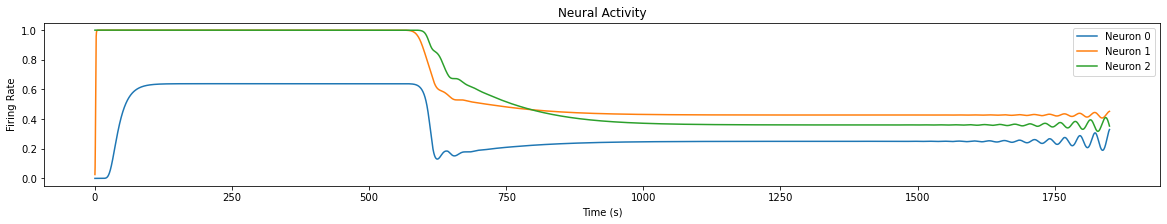

In [31]:
transient1 = 5000 #insteps
transient2 = 7000
testperiod = 500
duration = ((2*transient1)+transient2+(3*testperiod))/10
weights = np.array([[1.72785,3.7651,-1.20265],[2.78113,3.9261,7.3069],[12.543,4.16485,9.03816]])
biases = np.array([-15.8581,0.834461,3.26785])
timeconstants = np.array([9.42607,2.41159,7.85833])

C = CTRNN(3,0.1,duration,1,weights,biases,timeconstants)
C.setFacilitationFunctionParams(np.array([.25,.25,.25]),np.array([.75,.75,.75]),np.array([-4,-4,-4]))
C.setAdaptiveTimeConstants(np.array([40,40,40]),np.array([20,20,20]))
C.initializeState(invsigmoid(np.array([5.03977e-14,7.88983e-3,9.95847e-1])))
for i in range(transient1):
    C.ctrnnstep(0)
for i in range(testperiod):
    C.ctrnnstep(0)
for i in range(transient2):
    C.ctrnnstep(1)
for i in range(testperiod):
    C.ctrnnstep(1)
for i in range(transient1):
    C.ctrnnstep(0)
for i in range(testperiod):
    C.ctrnnstep(0)
    
C.plot()
print(C.Weights)
print(C.Biases)

[[ 6.07117015  1.14548563 -4.8905404 ]
 [ 9.77207573  1.19447116  1.78168765]
 [10.28478762  1.26710454  2.20383544]]
[-13.31052449  -1.5425938    0.45381791]


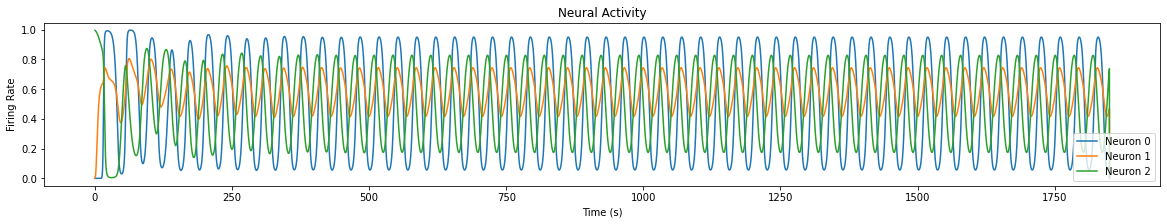

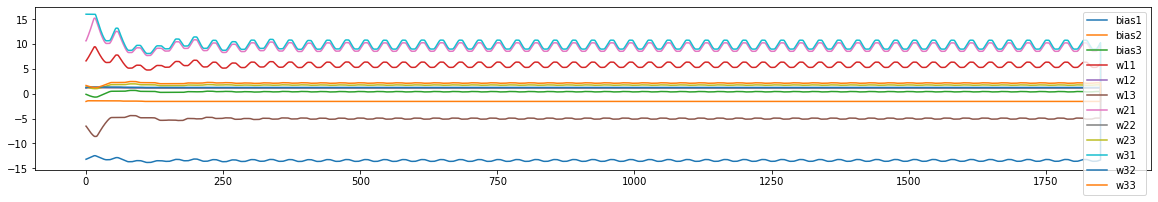

In [ ]:
weights = np.array([[6.60946,1.14559,-6.51152],[10.6385,1.19458,1.34445],[16,1.26722,1.663]])
biases = np.array([-13.1741,-1.54257,-0.114027])
timeconstants = np.array([9.42607,2.41159,7.85833])
C2 = CTRNN(3,0.1,duration,1,weights,biases,timeconstants)
C2.setFacilitationFunctionParams(np.array([.25,.25,.25]),np.array([.75,.75,.75]),np.array([-4,-4,-4]))
C2.setAdaptiveTimeConstants(np.array([40,40,40]),np.array([20,20,20]))
C2.initializeState(invsigmoid(np.array([5.03977e-14,7.88983e-3,9.95847e-1])))
for i in range(18499):
    C2.ctrnnstep(1)
print(C2.Weights)
print(C2.Biases)
C2.plot()
plt.show()
for i in range(3):
    plt.plot(C2.time,C2.bias_record[i],label = 'bias%s'%(i+1))
for i in range(3):
    for j in range(3):
        plt.plot(C2.time,C2.weight_record[i,j], label = 'w%s%s'%((i+1),(j+1)))
plt.legend()